In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

In [3]:
dataset_root = '/kaggle/input/shl-intern-hiring-assessment/dataset/'
train_audios_dir = dataset_root + 'audios_train/'
test_audios_dir = dataset_root + 'audios_test/'
os.listdir('/kaggle/input/shl-intern-hiring-assessment/dataset/')

['sample_submission.csv',
 'audios_test',
 'train.csv',
 'test.csv',
 'audios_train']

In [4]:
train_df = pd.read_csv(f'{dataset_root}train.csv')
train_df.head()

,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


In [5]:
print(f'Shape of train_df: {train_df.shape}')
print()
print(f'dtypes in train_df:\n{train_df.dtypes}')

Shape of train_df: (444, 2)

dtypes in train_df:
filename     object
label       float64
dtype: object


In [6]:
import librosa
from IPython.display import Audio
import random

# displaying a random sample from the training dataset
rand_sample = random.randint(1, train_df.shape[0])
print(f'random index: {rand_sample}')
rand_sample_path = train_audios_dir + train_df.iloc[rand_sample]['filename']
print(f'Random Audio Sample: {rand_sample_path}')
Audio(filename=rand_sample_path)

random index: 313
Random Audio Sample: /kaggle/input/shl-intern-hiring-assessment/dataset/audios_train/audio_105.wav


## Generate and visualize the following acoustic features of the audio file:
- ### mfcc (Mel-frequency Cepstral Coefficients)
- ### chroma_stft (Chroma Short-time Fourier Transform)
- ### zcr (Zero Crossing Rate)
- ### spec_centroid (Spectral Centroid)

audio time series: [ 3.0393468e-05  8.2893239e-05  7.6441036e-05 ... -3.1859507e-10
  2.3471819e-10  4.4247935e-11]
sampling rate: 22050



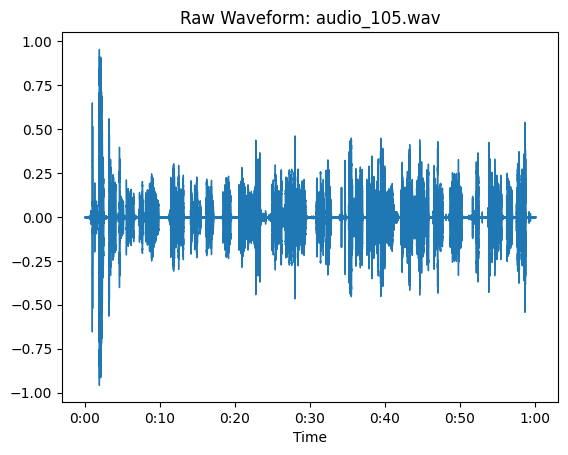

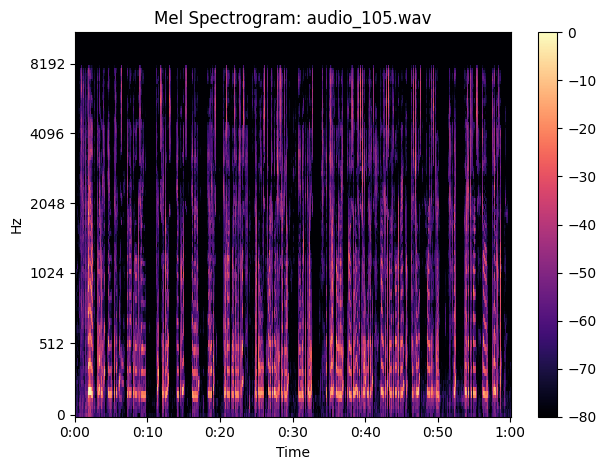

In [11]:
# generating raw waveform and mel spectogram for the random sample
y, sr = librosa.load(rand_sample_path)
print(f'audio time series: {y}')
print(f'sampling rate: {sr}')
print()

librosa.display.waveshow(y=y, sr=sr)
plt.title(f'Raw Waveform: {train_df.iloc[rand_sample]["filename"]}')
plt.show()

# fig, ax = plt.subplots()
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel')
plt.title(f'Mel Spectrogram: {train_df.iloc[rand_sample]["filename"]}')
plt.colorbar()
plt.tight_layout()
plt.show()

Shape of MFCC: (20, 2588)


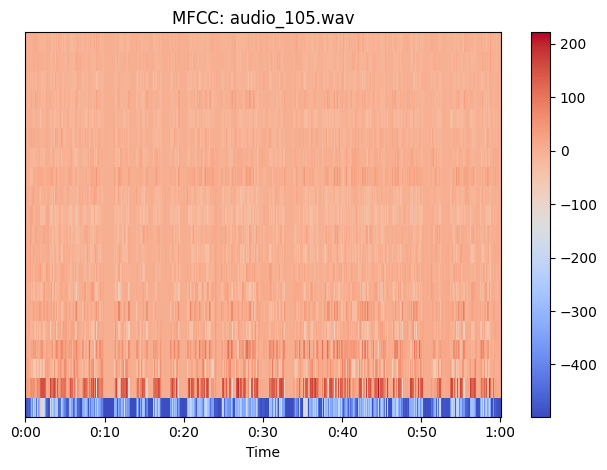

In [12]:
mfcc = librosa.feature.mfcc(y=y, sr=sr)
print(f'Shape of MFCC: {mfcc.shape}')

# fig, ax = plt.subplots()
librosa.display.specshow(mfcc, x_axis='time')
# ax.set(xlabel='time(s)')
plt.title(f'MFCC: {train_df.iloc[rand_sample]["filename"]}')
plt.colorbar()
plt.tight_layout()
plt.show()

Shape of Chroma STFT: (12, 2588)


<Figure size 1200x600 with 0 Axes>

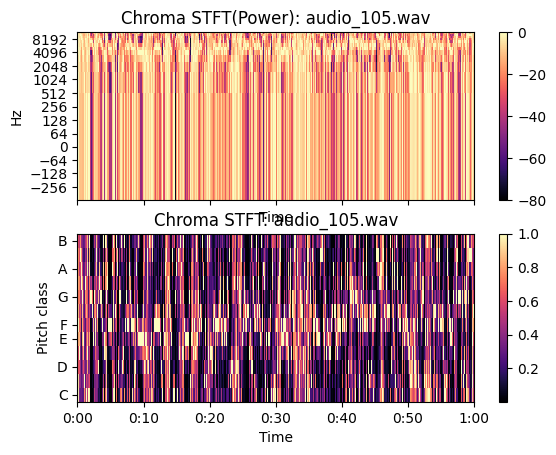

In [27]:
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
chroma_stft_db = librosa.amplitude_to_db(chroma_stft, ref=np.max)
print(f'Shape of Chroma STFT: {chroma_stft.shape}')

plt.figure(figsize=(12,6))
fig, ax = plt.subplots(nrows=2, sharex=True)

img = librosa.display.specshow(chroma_stft_db, x_axis='time', y_axis='log', ax=ax[0])
fig.colorbar(img, ax=ax[0])
ax[0].set(title=f'Chroma STFT(Power): {train_df.iloc[rand_sample]["filename"]}')

img = librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', ax=ax[1])
fig.colorbar(img, ax=ax[1])
ax[1].set(title=f'Chroma STFT: {train_df.iloc[rand_sample]["filename"]}')
# fig.tight_layout()
fig.show()

In [29]:
zcr = librosa.feature.zero_crossing_rate(y=y)
print(f'ZCR: {zcr}')
print(f'Shape of ZCR: {zcr.shape}')

ZCR: [[0.06542969 0.09375    0.13574219 ... 0.13037109 0.1328125  0.11230469]]
Shape of ZCR: (1, 2588)


In [30]:
spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
print(f'Spectral Centroid: {spec_centroid}')
print(f'Shape of Spectral Centroid: {spec_centroid.shape}')

Spectral Centroid: [[2021.15954955 2218.44921125 2494.28338252 ... 2209.19929311
  2258.08251722 2307.52593627]]
Shape of Spectral Centroid: (1, 2588)


## Function to extract acoustic features from the provided audio file

In [31]:
def extract_acoustic_features(audio_file_path):
    try:
        y, sr = librosa.load(audio_file_path)
        features = []
        
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))

        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        features.extend(np.mean(chroma_stft, axis=1))
        features.extend(np.std(chroma_stft, axis=1))

        zcr = librosa.feature.zero_crossing_rate(y=y)
        features.extend([np.mean(zcr), np.std(zcr)])

        spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        features.extend([np.mean(spec_centroid), np.std(spec_centroid)])

        return features
        
    except Error as e:
        print(f"Failed to process audio file: {audio_file_path}!")
        print(f"Error: {e}")
        return None

In [33]:
X = []
y = []

for idx, row in tqdm(train_df.iterrows(), desc='Extracting Acoustic Features: '):
    audio_file_path = train_audios_dir + row["filename"]
    features = extract_acoustic_features(audio_file_path)

    X.append(features)
    y.append(row["label"])

X = np.array(X)
y = np.array(y)

print(f'X: {X}')
print(f'Shape of X: {X.shape}')
print()
print(f'y: {y}')
print(f'Shape of y: {y.shape}')

Extracting Acoustic Features: : 444it [04:12,  1.76it/s]

X: [[-4.91022156e+02  5.09087448e+01  5.27431202e+00 ...  8.07536168e-02
   1.76687744e+03  8.56019453e+02]
 [-4.29440552e+02  3.21253014e+01 -4.88864470e+00 ...  1.30180092e-01
   2.08353244e+03  1.31727512e+03]
 [-4.84911224e+02  6.12827339e+01 -4.72917414e+00 ...  2.04134896e-01
   2.08107802e+03  1.27557044e+03]
 ...
 [-4.04007660e+02  9.91906509e+01 -5.36810875e-01 ...  1.44248805e-01
   2.05147846e+03  1.53258524e+03]
 [-4.60550690e+02  7.73222885e+01  4.30997963e+01 ...  5.47660644e-02
   1.11497745e+03  7.58846854e+02]
 [-3.39814178e+02  7.66723175e+01 -1.35273037e+01 ...  1.28468932e-01
   2.01430814e+03  1.37459319e+03]]
Shape of X: (444, 68)

y: [1.  1.5 1.5 1.5 2.  2.5 2.  2.  2.  2.5 2.  2.5 2.  2.5 2.  2.5 2.5 2.5
 2.  2.  2.  2.  2.  2.5 2.5 2.  2.5 2.  2.5 2.  2.  2.  2.5 2.5 2.  2.5
 2.  2.5 2.5 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.5 2.5 2.  2.  2.
 2.5 2.5 2.5 2.5 2.5 2.  2.  2.  2.  2.5 2.  2.  2.  2.5 2.  2.  2.  2.5
 2.5 2.  2.  2.  2.  2.  2.  2.5 2.5 2.  2.5

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Shape of X_train, y_train: ({X_train.shape, y_train.shape})')
print(f'Shape of X_test, y_test: ({X_test.shape, y_test.shape})')

Shape of X_train, y_train: (((355, 68), (355,)))
Shape of X_test, y_test: (((89, 68), (89,)))


In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

In [39]:
model = RandomForestRegressor(n_estimators=150, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150, random_state=42)

In [40]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
pearsonr_coeff, _ = pearsonr(y_test, y_pred)

print(f'MAE: {mae:.3f}')
print(f'MSE: {mse:.3f}')
print(f'Pearson Correlation: {pearsonr_coeff:.3f}')

MAE: 0.770
MSE: 0.879
Pearson Correlation: 0.618


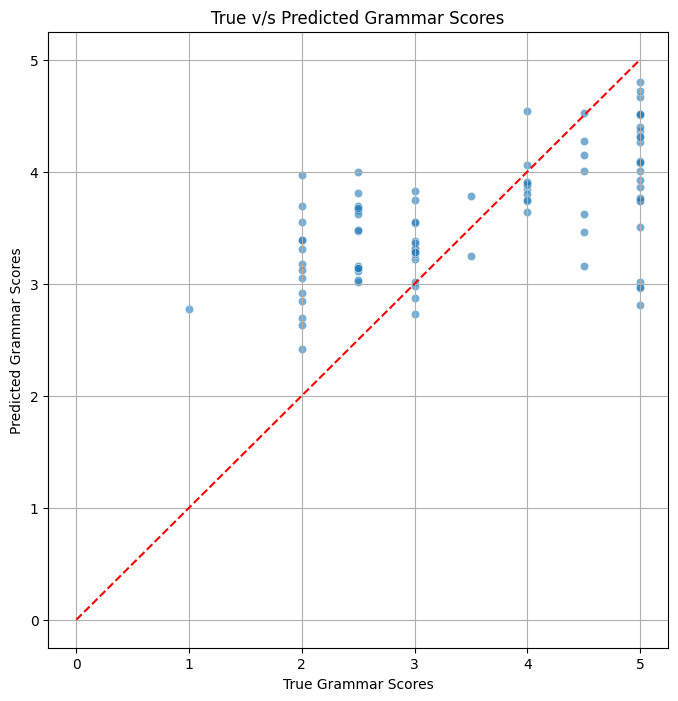

In [43]:
# Plot the true scores v/s predicted scores
plt.figure(figsize=(8,8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([0, 5], [0, 5], 'r--')
plt.xlabel('True Grammar Scores')
plt.ylabel('Predicted Grammar Scores')
plt.title('True v/s Predicted Grammar Scores')
plt.grid(True)
plt.show()

## Predict Scores for submission

In [44]:
test_df = pd.read_csv(dataset_root+'test.csv')
test_df.head()

,filename
0,audio_706.wav
1,audio_800.wav
2,audio_68.wav
3,audio_1267.wav
4,audio_683.wav


In [48]:
X_sub = []
sub_filenames = []
for idx, row in tqdm(test_df.iterrows(), desc='Extracting acoustic features for Test Dataset: '):
    audio_file_path = test_audios_dir + row["filename"]
    sub_filenames.append(row["filename"])
    features = extract_acoustic_features(audio_file_path)
    X_sub.append(features)

X_sub = np.array(X_sub)
print(f'X_sub: {X_sub}')
print(f'Shape of X_sub: {X_sub.shape}')
print(f'sub_filenames: {sub_filenames}')
print(f'Length of sub_filenames: {len(sub_filenames)}')

Extracting acoustic features for Test Dataset: : 195it [01:34,  2.06it/s]

X_sub: [[-3.58413452e+02  9.73485641e+01 -2.13909302e+01 ...  5.53899198e-02
   1.63972742e+03  5.70447169e+02]
 [-3.39925415e+02  1.09508606e+02 -2.70276279e+01 ...  5.08945636e-02
   1.60147472e+03  5.09801199e+02]
 [-4.08821808e+02  1.40407455e+02  2.52925129e+01 ...  9.78157894e-02
   1.32440398e+03  1.11486720e+03]
 ...
 [-3.93709534e+02  9.96961060e+01  1.87322083e+01 ...  8.86837003e-02
   1.32042181e+03  1.04735373e+03]
 [-3.49862976e+02  1.05094749e+02  1.01927109e+01 ...  5.81705471e-02
   1.29210031e+03  8.63868008e+02]
 [-3.62692627e+02  1.00712891e+02 -1.42212181e+01 ...  6.54842910e-02
   1.27660914e+03  6.97376002e+02]]
Shape of X_sub: (195, 68)
sub_filenames: ['audio_706.wav', 'audio_800.wav', 'audio_68.wav', 'audio_1267.wav', 'audio_683.wav', 'audio_1242.wav', 'audio_908.wav', 'audio_888.wav', 'audio_137.wav', 'audio_770.wav', 'audio_735.wav', 'audio_1026.wav', 'audio_1214.wav', 'audio_1122.wav', 'audio_1022.wav', 'audio_726.wav', 'audio_1205.wav', 'audio_1116.wav', 'a

In [56]:
y_sub = model.predict(X_sub)
print(f'y_sub: {y_sub}')
print(f'Shape of y_sub: {y_sub.shape}')

df_sub = pd.DataFrame({
    'filename': sub_filenames,
    'label': y_sub
})

print(f'df_sub:\n{df_sub}')
print(f'Shape of df_sub: {df_sub.shape}')

y_sub: [3.08333333 2.98333333 3.70666667 3.9        2.94       2.79
 3.06       2.98       3.49       2.49666667 3.77333333 3.01333333
 2.94333333 2.86666667 2.99333333 3.03666667 3.13666667 2.59333333
 3.31333333 3.79       4.27666667 3.36333333 3.39       3.67666667
 3.97333333 3.49666667 3.31333333 3.10666667 2.96       3.25
 2.80333333 2.79333333 3.35       2.74333333 3.74666667 2.67
 3.54       3.37333333 3.33666667 2.54666667 3.12333333 3.08333333
 3.17666667 3.04333333 3.20666667 3.45666667 3.9        3.4
 4.15666667 3.98       3.51666667 3.47666667 3.59666667 2.97666667
 3.49666667 3.19333333 3.92333333 3.35       2.86       3.25666667
 3.93666667 4.35666667 3.37666667 3.35666667 3.63333333 2.89
 3.08333333 2.83       3.14       3.38333333 3.29       3.31333333
 3.81       3.40666667 2.96333333 2.48666667 3.22333333 3.75666667
 3.62       3.33333333 4.03       4.12333333 3.10333333 3.17666667
 3.15666667 3.6        3.78       3.52666667 3.88666667 3.62
 3.76       3.51       3.

In [55]:
df_sub.to_csv('submission.csv', index=False)